# TUIA / AAII - TP2: Redes Recurrentes y Transformers - Problema 2

> *Modelo de generación de textos basados en RNN para escribir noticias falsas.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [1]:
# Data
import os
import pathlib
import numpy as np

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import plotly.graph_objects as go

# ML metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc

# Redes Neuronales
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
# from tensorflow.keras.models import Sequential, load_model, save_model
# from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LSTM

# Semillas para reproductibilidad
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [12]:
import tensorflow as tf
import numpy as np
import os
import time
from pathlib import Path
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import string

# Descargar recursos de nltk si es necesario
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### GPU

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Dataset

El dataset proporcionado incluye 120000 artículos correspondientes a 4 categorías distintas. En este caso, la categoría no es relevante, sólo utilizaremos el dataset como un cuerpo de texto para entrenar un modelo recurrente de generación de texto.
https://www.tensorflow.org/datasets/catalog/ag_news_subset

### Descarga

In [6]:
# Cargar el dataset ag_news
df, info = tfds.load('ag_news_subset', with_info=True, as_supervised=True)

In [7]:
train_ds, val_ds = df['train'], df['test']

## Análisis Exploratorio

In [8]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Inspeccionamos el dataset el cual posee los siguientes labels:

* 0 = World
* 1 = Sports
* 2 = Business
* 3 = Sci/Tech

In [9]:
for example, label in train_ds.take(6):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
label:  3
text:  b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
label:  1
text:  b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
label:  2
text:  b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.'
label:  3
text:  b'London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.'
label:

In [10]:
# Función para extraer el texto del dataset
def extract_text(data):
    text = ''
    for article, _ in data:
        text += article.numpy().decode('utf-8') + ' '
    return text

# Extraer el texto de los conjuntos de entrenamiento y prueba
train_text = extract_text(train_ds)
test_text = extract_text(val_ds)

# Unir todos los textos en uno solo
text = train_text + test_text

# Mostrar una muestra del texto
print(text[:500])

AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions. Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season. President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local


In [13]:
# Tokenizar el texto en palabras y oraciones
words = word_tokenize(text)
sentences = sent_tokenize(text)

# Contar palabras y oraciones
word_count = len(words)
sentence_count = len(sentences)
unique_words = len(set(words))

print(f'Total de palabras: {word_count}')
print(f'Total de oraciones: {sentence_count}')
print(f'Palabras únicas: {unique_words}')

Total de palabras: 4576341
Total de oraciones: 143487
Palabras únicas: 107288


In [ ]:
# Frecuencia de palabras
word_freq = Counter(words)
most_common_words = word_freq.most_common(10)

# Frecuencia de caracteres
char_freq = Counter(text)
most_common_chars = char_freq.most_common(10)

# Graficar las palabras más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x=[word for word, freq in most_common_words], y=[freq for word, freq in most_common_words])
plt.title('Top 10 palabras más comunes')
plt.show()

# Graficar los caracteres más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x=[char for char, freq in most_common_chars], y=[freq for char, freq in most_common_chars])
plt.title('Top 10 caracteres más comunes')
plt.show()

In [ ]:
# Longitud de las palabras
word_lengths = [len(word) for word in words]

# Longitud de las oraciones
sentence_lengths = [len(sentence.split()) for sentence in sentences]

# Graficar la distribución de la longitud de las palabras
plt.figure(figsize=(12, 6))
sns.histplot(word_lengths, bins=30, kde=True)
plt.title('Distribución de la longitud de palabras')
plt.xlabel('Longitud de Palabra')
plt.ylabel('Frecuencia')
plt.show()

# Graficar la distribución de la longitud de las oraciones
plt.figure(figsize=(12, 6))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.title('Distribución de la longitud de oraciones')
plt.xlabel('Longitud de Oración')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
print(f'Length of text: {len(text)} characters')

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)


In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

# RNN / Caracter a caracter

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

## Modelo

### Definición y entrenamiento

In [ ]:
# Definición del Modelo
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

In [ ]:
model.summary()

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Este modelo consiste en una capa de entrada seguida de dos capas ocultas, cada una con 16 neuronas y activadas por la función ReLU, con una capa de dropout entre ellas para regularización, y una capa de salida con una sola neurona y activación sigmoide. Este tipo de arquitectura es comúnmente utilizada en problemas de clasificación binaria.

### Entrenamiento

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['chicago'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['The Argentina', 'The Argentina', 'The Argentina', 'The Argentina', 'The Argentina'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

In [ ]:
# Entrenamiento
print("Inicio del Entrenamiento\n-------------------------")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, verbose=1)
print("-------------------------\nFin del Entrenamiento")

Inicio del Entrenamiento
Epoch 1/200
8/8 [==============================] - 1s 43ms/step - loss: 0.7094 - accuracy: 0.3564 - val_loss: 0.6994 - val_accuracy: 0.3659
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.7041 - accuracy: 0.3829 - val_loss: 0.6951 - val_accuracy: 0.3740
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.6993 - accuracy: 0.3910 - val_loss: 0.6915 - val_accuracy: 0.5366
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.4990 - val_loss: 0.6891 - val_accuracy: 0.6585
Epoch 5/200
8/8 [==============================] - 0s 11ms/step - loss: 0.6926 - accuracy: 0.6069 - val_loss: 0.6879 - val_accuracy: 0.6748
Epoch 6/200
8/8 [==============================] - 0s 10ms/step - loss: 0.6893 - accuracy: 0.6253 - val_loss: 0.6867 - val_accuracy: 0.6423
Epoch 7/200
8/8 [==============================] - 0s 11ms/step - loss: 0.6866 - accuracy: 0.6456 - val_loss: 0.6857 - val_accuracy: 0.65

### Visualización de Métricas

In [ ]:
# Evaluación del modelo en el conjunto de prueba
predictions_prob = model.predict(X_test)
# Aplicar umbral para obtener etiquetas binarias
threshold = 0.5  # Ajusta el umbral según sea necesario
predictions = (predictions_prob > threshold).astype(int)

5/5 [==============================] - 0s 3ms/step


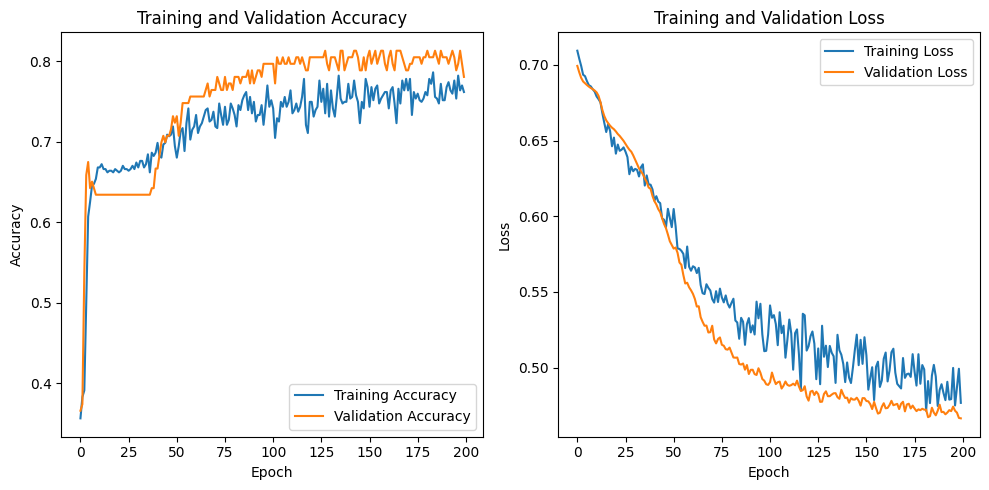

In [ ]:
# Obtener las métricas de precisión y pérdida del historial
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Usar el número de épocas del entrenamiento

plt.figure(figsize=(10, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("--------------------------")
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_score = 2 * (precision * recall) / (precision + recall)
conf_matrix = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-Score: {:.2f}%".format(f1_score * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

--------------------------
Accuracy: 79.87%
Precision: 80.00%
Recall: 62.07%
F1-Score: 69.90%

Confusion Matrix:
 [[87  9]
 [22 36]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.91      0.85        96
         1.0       0.80      0.62      0.70        58

    accuracy                           0.80       154
   macro avg       0.80      0.76      0.77       154
weighted avg       0.80      0.80      0.79       154



## Predicciones

# RNN / Palabra a palabra

# Observaciones finales

Aunque las métricas obtenidas no son del todo malas para el problema de clasificación, los resultados están lejos de ser los deseados para esta situación. Numerosas pruebas y ensayos con distintas configuraciones y arquitecturas motivaron la decisión de reemplazar esta actividad por la denominada "Problema 2b" por lo que se interrumpe la experimentación y se continúa el trabajo con el siguiente.